# Sparsity analysis

In [12]:
import torch
from collections import deque
import os

import networkx as nx
import dgl

import matplotlib.pyplot as plt
import numpy as np

import polygraphs as pg
from polygraphs import graphs
from polygraphs import hyperparameters as hparams
from polygraphs import visualisations as viz
from polygraphs import ops

%matplotlib inline

## Static analysis

### A. Measures

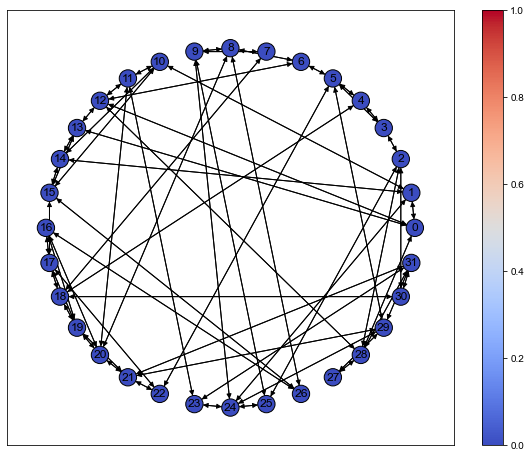

In [13]:
params = hparams.NetworkHyperParameters()
params.kind = 'wattsstrogatz'
params.size = 32
params.wattsstrogatz.knn = 4
params.wattsstrogatz.probability = 0.5
params.selfloop = False

# Calling graph constructor indirectly
graph = graphs.create(params)
_ = viz.draw(graph, figsize=(10, 8), layout='circular')

#### Sparsity

In [14]:
def sparsity(graph):
    """
    Returns sparsity level of given DGL graph.
    """
    # Assumes an adjacency matrix of size N x N with M non-zero values
    return graph.num_edges() / (graph.num_nodes() ** 2)


sparsity(graph)

0.125

#### Clustering coefficient

In [15]:
def acc(graph):
    """
    Returns average clustering coefficient.
    """
    graphx = nx.DiGraph(dgl.to_networkx(graph))
    return nx.algorithms.cluster.average_clustering(graphx)


acc(graph)

0.16145833333333331

#### Average path length

In [16]:
def apl(graph):
    """
    Returns average shortest path length.
    """
    graphx = nx.DiGraph(dgl.to_networkx(graph))
    return nx.average_shortest_path_length(graphx)


apl(graph)

2.6129032258064515

## Dynamic analysis

In [26]:
# Create a PolyGraph configuration
params = hparams.PolyGraphHyperParameters()

# Initial beliefs are random uniform between 0 and 1
params.init.kind = 'uniform'
# Chance that action B is better than action A
params.epsilon = 0.001

params.network.kind = 'wattsstrogatz'
params.network.size = 128
params.network.wattsstrogatz.knn = 4
params.network.wattsstrogatz.probability = 0.2

# Enable logging; print progress every 100 steps
params.logging.enabled = True
params.logging.interval = 100

# Take snapshots
params.snapshots.enabled = True
params.snapshots.interval = 100

params.simulation.steps = 0
params.simulation.repeats = 1

# Store results in directory
params.simulation.results = "data/test3"

# Set seed
params.seed = 123456789

pg.random(params.seed)
_ = pg.simulate(params, op=ops.BalaGoyalOp)

[MON] step 0001 Ksteps/s   0.00 A/B 0.45/0.55
[MON] step 0100 Ksteps/s   0.19 A/B 0.47/0.53
[MON] step 0200 Ksteps/s   0.19 A/B 0.48/0.52
[MON] step 0300 Ksteps/s   0.20 A/B 0.48/0.52
[MON] step 0400 Ksteps/s   0.22 A/B 0.49/0.51
[MON] step 0500 Ksteps/s   0.23 A/B 0.49/0.51
[MON] step 0600 Ksteps/s   0.24 A/B 0.46/0.54
[MON] step 0700 Ksteps/s   0.25 A/B 0.50/0.50
[MON] step 0800 Ksteps/s   0.25 A/B 0.51/0.49
[MON] step 0900 Ksteps/s   0.25 A/B 0.48/0.52
[MON] step 1000 Ksteps/s   0.26 A/B 0.48/0.52
[MON] step 1100 Ksteps/s   0.26 A/B 0.45/0.55
[MON] step 1200 Ksteps/s   0.26 A/B 0.44/0.56
[MON] step 1300 Ksteps/s   0.27 A/B 0.48/0.52
[MON] step 1400 Ksteps/s   0.27 A/B 0.46/0.54
[MON] step 1500 Ksteps/s   0.27 A/B 0.47/0.53
[MON] step 1600 Ksteps/s   0.27 A/B 0.42/0.58
[MON] step 1700 Ksteps/s   0.27 A/B 0.45/0.55
[MON] step 1800 Ksteps/s   0.26 A/B 0.42/0.58
[MON] step 1900 Ksteps/s   0.26 A/B 0.41/0.59
[MON] step 2000 Ksteps/s   0.26 A/B 0.42/0.58
[MON] step 2100 Ksteps/s   0.27 A/

In [27]:
import h5py


def sparsity(graph):
    """
    Returns sparsity level of given DGL graph.
    """
    # Remove self-loops
    g = dgl.remove_self_loop(graph)
    # Assumes an adjacency matrix of size N x N with M non-zero values
    return g.num_edges() / (g.num_nodes() ** 2)


def acc(graph):
    """
    Returns average clustering coefficient.
    """
    graphx = nx.DiGraph(dgl.to_networkx(graph))
    return nx.algorithms.cluster.average_clustering(graphx)


def apl(graph):
    """
    Returns average shortest path length.
    """
    graphx = nx.DiGraph(dgl.to_networkx(graph))
    return nx.average_shortest_path_length(graphx)


def filterfn(edges):
    return torch.le(edges.src["beliefs"], 0.5)
   

def postprocess(directory, id):
    """
    Post-process graph snapshots
    """
    # Resulting hashtable
    ht = {}
    graphs, _ = dgl.load_graphs(os.path.join(directory, f"{id}.bin"))
    graph = graphs[0]
    fp = h5py.File(os.path.join(directory, f"{id}.hd5"), "r")
    _keys = [int(key) for key in fp.keys()]
    _keys = sorted(_keys)
    for key in _keys:
        graph.ndata["beliefs"] = torch.tensor(fp[str(key)][:])
        # Filter any edge whose source has belief less than 0.5
        inactive = graph.filter_edges(filterfn)
        # Create subgraph
        subgraph = dgl.remove_edges(graph, inactive)
        # Debugging
        s = 'DBG> '
        s += f'From G({graph.num_nodes():3d}, {graph.num_edges():3d})'
        s += f'to G\'({subgraph.num_nodes():3d}, {subgraph.num_edges():3d})'
        print(s)
        # Compute network statistics
        ht[key] = sparsity(subgraph)
    return ht


ht = postprocess("data/test3", 1)
print(ht)

DBG> From G(128, 640)to G'(128, 345)
DBG> From G(128, 640)to G'(128, 337)
DBG> From G(128, 640)to G'(128, 333)
DBG> From G(128, 640)to G'(128, 334)
DBG> From G(128, 640)to G'(128, 323)
DBG> From G(128, 640)to G'(128, 323)
DBG> From G(128, 640)to G'(128, 344)
DBG> From G(128, 640)to G'(128, 317)
DBG> From G(128, 640)to G'(128, 310)
DBG> From G(128, 640)to G'(128, 327)
DBG> From G(128, 640)to G'(128, 328)
DBG> From G(128, 640)to G'(128, 347)
DBG> From G(128, 640)to G'(128, 355)
DBG> From G(128, 640)to G'(128, 331)
DBG> From G(128, 640)to G'(128, 343)
DBG> From G(128, 640)to G'(128, 336)
DBG> From G(128, 640)to G'(128, 369)
DBG> From G(128, 640)to G'(128, 353)
DBG> From G(128, 640)to G'(128, 370)
DBG> From G(128, 640)to G'(128, 378)
DBG> From G(128, 640)to G'(128, 369)
DBG> From G(128, 640)to G'(128, 355)
DBG> From G(128, 640)to G'(128, 383)
DBG> From G(128, 640)to G'(128, 383)
DBG> From G(128, 640)to G'(128, 400)
DBG> From G(128, 640)to G'(128, 397)
DBG> From G(128, 640)to G'(128, 398)
D

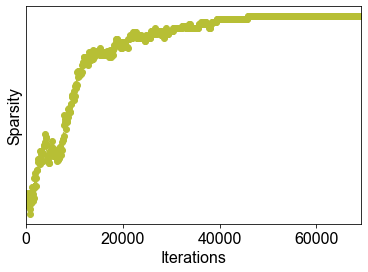

In [32]:
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 16})

# Configure the y-axis - find max value and use discrete steps
# plt.ylim([0, 0.1])
plt.yticks(np.arange(0, 1., 0.2))
plt.ylabel('Sparsity')
# Configure the x-axis
plt.xlim([0, max(ht.keys())])
plt.xlabel('Iterations')
# Create a bar chart
plt.plot(ht.keys(), 
         ht.values(),
         '--o',
         color='#B7BF35')

In [ ]:
g = dgl.graph((torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])))
g

In [ ]:
g.ndata['test'] = torch.tensor([10, 10, 10, 3])

In [ ]:
g.edges()

In [ ]:
def filterfn(edges):
    print(edges.src['test'])
    result = torch.gt(edges.src["test"], 0.0)
    print(result)
    return result

result = g.filter_edges(filterfn)
result